In [5]:
import pandas as pd
import os
import glob
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Set the base directory
base_dir = Path.cwd().parent

data_dir = os.path.join(base_dir, 'data')
preprocessed_dir = os.path.join(data_dir, 'preprocessed')
base_data_dir = os.path.join(data_dir, 'base')
summaries_dir = os.path.join(base_dir, 'summaries')

# 1. Import bmdata from data/preprocessed
# Check what's in the balancing_prices directory
balancing_prices_dir = os.path.join(preprocessed_dir, 'balancing_prices')

# Load balancing prices data
# This assumes the data is organized in CSV files within the balancing_prices directory
balancing_prices_files = glob.glob(os.path.join(balancing_prices_dir, '*.csv'))
bmdata = {}
if balancing_prices_files:
    for file in balancing_prices_files[:5]:  # Load first 5 files as example
        filename = os.path.basename(file)
        print(f"Loading {filename}")
        bmdata[filename] = pd.read_csv(file)
    print(f"Loaded {len(balancing_prices_files)} balancing price files")
else:
    print("No balancing price files found")

# Load other preprocessed data
load_weights = pd.read_csv(os.path.join(preprocessed_dir, 'load_weights.csv'))
prepared_bmus = pd.read_csv(os.path.join(preprocessed_dir, 'prepared_bmus.csv'))

# 2 & 3. Import balancing volumes and physical notifications from data/base/*
# Get a list of all date directories
date_dirs = sorted(glob.glob(os.path.join(base_data_dir, '????-??-??')))

# Sample data from a few dates
sample_dates = date_dirs[:3]  # First 3 dates
balancing_volumes = {}
physical_notifications_data = {}

for date_dir in sample_dates:
    date = os.path.basename(date_dir)
    print(f"\nLoading data for {date}")
    
    # Load physical notifications
    pn_file = os.path.join(date_dir, 'physical_notifications.csv')
    if os.path.exists(pn_file):
        physical_notifications_data[date] = pd.read_csv(pn_file)
        print(f"Loaded physical notifications: {physical_notifications_data[date].shape}")
    
    # Load bids and offers (balancing volumes)
    bids_file = os.path.join(date_dir, 'bids.csv')
    offers_file = os.path.join(date_dir, 'offers.csv')
    
    if os.path.exists(bids_file) and os.path.exists(offers_file):
        bids = pd.read_csv(bids_file)
        offers = pd.read_csv(offers_file)
        balancing_volumes[date] = {
            'bids': bids,
            'offers': offers
        }

marginal_prices_file = os.path.join(summaries_dir, 'marginal_prices_summary_flex.csv')

if os.path.exists(marginal_prices_file):
    # This file might be large, so we'll read just a sample
    marginal_prices = pd.read_csv(marginal_prices_file, nrows=1000)


# Function to combine data from multiple dates if needed
def combine_daily_data(data_dict, key=None):
    """Combine data from multiple dates into a single DataFrame"""
    combined = []
    for date, data in data_dict.items():
        if key:
            df = data[key].copy()
        else:
            df = data.copy()
        df['date'] = date
        combined.append(df)
    return pd.concat(combined, ignore_index=True)

# Example: Combine physical notifications from multiple dates
if physical_notifications_data:
    combined_pn = combine_daily_data(physical_notifications_data)

Loading 2022-week01.csv
Loading 2022-week02.csv
Loading 2022-week03.csv
Loading 2022-week04.csv
Loading 2022-week05.csv
Loaded 166 balancing price files

Loading data for 2022-01-01
Loaded physical notifications: (48, 1407)

Loading data for 2022-01-02
Loaded physical notifications: (48, 1407)

Loading data for 2022-01-03
Loaded physical notifications: (48, 1407)


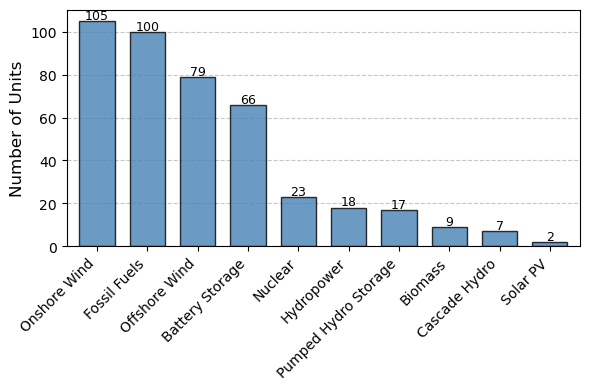

In [17]:
bmus = prepared_bmus.copy()
ss = bmus.loc[~bmus.carrier.isin(['interconnector', 'load', 'demand_flex'])]

# Create a bar plot of carrier counts
fig, ax = plt.subplots(figsize=(6, 4))

# Get the value counts and rename for nicer display
counts = ss.carrier.value_counts()

# Define nicer display names
nice_names = {
    'onwind': 'Onshore Wind',
    'fossil': 'Fossil Fuels',
    'offwind': 'Offshore Wind',
    'battery': 'Battery Storage',
    'nuclear': 'Nuclear',
    'hydro': 'Hydropower',
    'PHS': 'Pumped Hydro Storage',
    'biomass': 'Biomass',
    'cascade': 'Cascade Hydro',
    'solar': 'Solar PV'
}

# Create a new Series with nice names
counts_renamed = pd.Series(
    counts.values,
    index=[nice_names.get(carrier, carrier) for carrier in counts.index]
)

# Plot with styling
bars = counts_renamed.plot(
    kind='bar',
    color='steelblue',
    edgecolor='black',
    alpha=0.8,
    width=0.7,
    ax=ax
)

# Add styling
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_ylabel('Number of Units', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_axisbelow(True)

fig.tight_layout()

# Add count values on top of bars
for bar in bars.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2.,
        height + 1,
        f'{int(height)}',
        ha='center',
        fontsize=9
    )

plt.savefig('model_bmu_carrier_count.pdf', bbox_inches='tight')

In [50]:
bmus.head()

,NationalGridBmUnit,carrier,bus,lon,lat
0,IBG-EGEN1,interconnector,4969,0.6530000000000001,51.46000000000001
1,IBG-ENGI1,interconnector,4969,0.6530000000000001,51.46000000000001
2,IBG-RSQ1,interconnector,4969,0.6530000000000001,51.46000000000001
3,IVD-VKL1,interconnector,7909,-0.221,52.931
4,IVG-VKL1,interconnector,7909,-0.221,52.931


In [51]:
cap = pd.read_csv(Path.cwd().parent / 'data' / 'preprocessed' / 'battery_phs_capacities.csv', index_col=0)
cap['max_hours'] = cap['energy_cap[MWh]'] / cap['power_cap[MW]']
cap.sort_values('energy_cap[MWh]', ascending=False, inplace=True)
cap['carrier'] = bmus.set_index('NationalGridBmUnit').loc[cap.index, 'carrier']

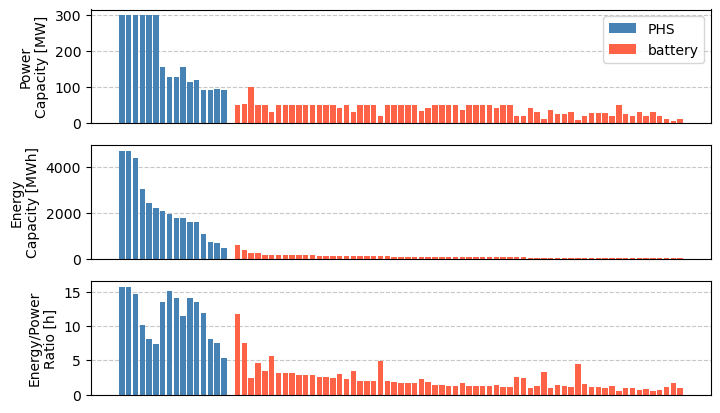

In [53]:
fig, axs = plt.subplots(3, 1, figsize=(8, 5))

# Define colors for different carriers
carrier_colors = {
    'battery': 'tomato',
    'PHS': 'steelblue',
    # Add more carriers if needed
}

for i, (col, ax) in enumerate(zip(cap.columns, axs)):
    # Group by carrier and color accordingly
    for carrier in cap['carrier'].unique():
        mask = cap['carrier'] == carrier
        color = carrier_colors.get(carrier, 'gray')  # Default to gray if carrier not in dict
        ax.bar(
            cap.index[mask], 
            cap.loc[mask, col], 
            label=carrier if i == 0 else None,  # Only add label in first subplot
            color=color
        )
    
    ax.set_xticks([])  # Remove all xticks
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    
    # Only add legend to the first subplot
    if i == 0:
        ax.legend(loc='best')

axs[0].set_ylabel('Power\nCapacity [MW]')
axs[1].set_ylabel('Energy\nCapacity [MWh]')
axs[2].set_ylabel('Energy/Power\nRatio [h]')

plt.savefig('storage_capacities.pdf', bbox_inches='tight')
plt.show()

In [43]:
cap.index

Index(['DINO-4', 'DINO-3', 'DINO-1', 'DINO-6', 'DINO-5', 'DINO-2', 'FOYE-1',
       'CRUA-2', 'CRUA-1', 'FOYE-2', 'CRUA-3', 'CRUA-4', 'FFES-1', 'FFES-4',
       'FFES-2', 'AG-MSTK01', 'FFES-3', 'WISHB-1', 'DOLLB-1', 'CLAYB-2',
       'LITRB-1', 'AG-ZEN03J', 'PILLB-2', 'CLAYB-1', 'SKELB-1', 'AG-ASTK05',
       'BUSTB-1', 'CHAPB-1', 'THMRB-1', 'ILMEB-1', 'PILLB-1', 'ARNKB-1',
       'AG-HEL00G', 'JAMBB-1', 'WHLWB-1', 'AG-HEL0CP', 'COVNB-1', 'ZEN02A',
       'AG-PFLX01', 'COWB-1', 'AG-HSTK01', 'NEWTB-1', 'BFSE01', 'CONTB-1',
       'CUPAB-1', 'AG-HLIM03', 'BURWB-1', 'AG-MFLX02', 'AG-HSTK02', 'ARBRB-1',
       'KEMB-1', 'AG-HLIM04', 'AG-HEL0DN', 'BROFB-1', 'BARNB-1', 'TOLLB-1',
       'NURSB-1', 'FARNB-1', 'HAWKB-1', 'AG-HLIM02', 'NFSE02', 'BROAB-1',
       'POTES-1', 'PINFB-2', 'PINFB-1', 'AG-LLIM01', 'BHOLB-1', 'AG-GEDF02',
       'PINFB-3', 'PINFB-4', 'AG-LLIM02', 'AG-GEDF01', 'ROOSB-1', 'FFSE01',
       'AG-HLIM01', 'WBURB-41', 'CRSSB-1', 'WBURB-43', 'AG-CBS06B', 'PNYCB-1',
       'AG-